In [1]:
reset -fs

In [2]:
import os
from urllib.request import urlretrieve

In [3]:
url = "http://www.cs.cornell.edu/People/pabo/movie-review-data/"
filename = "review_polarity.tar.gz"

In [4]:
if not os.path.exists(filename):
    filename, _ = urlretrieve(url+filename, filename)

In [5]:
import tarfile

In [6]:
path = "./txt_sentoken/"

In [7]:
if not os.path.exists(path):
    with tarfile.open(filename, "r:gz") as tar:
        tar.extractall()

-----

In [8]:
from sklearn.datasets import load_files

In [9]:
# Load data
sentiment = load_files(path, 
                       encoding='utf-8',
                       random_state=42)
sentiment.target_names

['neg', 'pos']

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
# Create train/test split with labels
train_data, test_data, train_target, test_target = train_test_split(sentiment.data,
                                                                    sentiment.target,
                                                                    random_state=42)

In [12]:
from sklearn.feature_extraction.text import CountVectorizer

In [13]:
# Transform train data from a list of strings into a matrix of frequency counts
vectorizer_count = CountVectorizer()
vectorized_count_train_data = vectorizer_count.fit_transform(train_data)

In [14]:
print("There are {:,} words in the vocabulary.".format(len(vectorizer_count.vocabulary_)))
print("'{}' appers {:,} times.".format('bacon', vectorizer_count.vocabulary_['bacon']))

There are 35,350 words in the vocabulary.
'bacon' appers 2,600 times.


In [15]:
from sklearn.naive_bayes import MultinomialNB

In [16]:
# Create an instance of the Naive Bayes class 
clf = MultinomialNB()
# Call fit method
clf.fit(vectorized_count_train_data, train_target)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [17]:
accuracy = clf.score(vectorizer_count.transform(test_data), test_target)

In [18]:
print("The accuracy on the test data is {:.2%}".format(accuracy))

The accuracy on the test data is 82.00%


-----

Use tf-idf

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [20]:
# Transform train data from a list of strings into a matrix of frequency counts
vectorizer_tf_idf = TfidfVectorizer()
vectorized_train_data = vectorizer_tf_idf.fit_transform(train_data)

In [21]:
# Create an instance of the Naive Bayes class 
clf_tf_idf = MultinomialNB()
# Call fit method
clf_tf_idf.fit(vectorized_train_data, train_target)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [22]:
print("The accuracy on the test data is {:.2%}".format(clf.score(vectorizer_tf_idf.transform(test_data), test_target)))

The accuracy on the test data is 81.00%


-----

In [23]:
from sklearn.metrics import confusion_matrix

In [24]:
help(confusion_matrix)

Help on function confusion_matrix in module sklearn.metrics.classification:

confusion_matrix(y_true, y_pred, labels=None, sample_weight=None)
    Compute confusion matrix to evaluate the accuracy of a classification
    
    By definition a confusion matrix :math:`C` is such that :math:`C_{i, j}`
    is equal to the number of observations known to be in group :math:`i` but
    predicted to be in group :math:`j`.
    
    Thus in binary classification, the count of true negatives is
    :math:`C_{0,0}`, false negatives is :math:`C_{1,0}`, true positives is
    :math:`C_{1,1}` and false positives is :math:`C_{0,1}`.
    
    Read more in the :ref:`User Guide <confusion_matrix>`.
    
    Parameters
    ----------
    y_true : array, shape = [n_samples]
        Ground truth (correct) target values.
    
    y_pred : array, shape = [n_samples]
        Estimated targets as returned by a classifier.
    
    labels : array, shape = [n_classes], optional
        List of labels to index the m

In [25]:
cm_train = confusion_matrix(train_target,
                            clf_tf_idf.predict(vectorizer_tf_idf.transform(train_data)))
cm_train

array([[756,   3],
       [ 75, 666]])

In [26]:
cm_test = confusion_matrix(test_target,
                 clf_tf_idf.predict(vectorizer_tf_idf.transform(test_data)))
cm_test

array([[223,  18],
       [100, 159]])

In [27]:
def show_confusion_matrix(C,class_labels=['0','1']):
    """
    C: ndarray, shape (2,2) as given by scikit-learn confusion_matrix function
    class_labels: list of strings, default simply labels 0 and 1.

    Draws confusion matrix with associated metrics.
    Source: http://notmatthancock.github.io/2015/10/28/confusion-matrix.html
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    assert C.shape == (2,2), "Confusion matrix should be from binary classification only."
    
    # true negative, false positive, etc...
    tn = C[0,0]; fp = C[0,1]; fn = C[1,0]; tp = C[1,1];

    NP = fn+tp # Num positive examples
    NN = tn+fp # Num negative examples
    N  = NP+NN

    fig = plt.figure(figsize=(8,8))
    ax  = fig.add_subplot(111)
    ax.imshow(C, interpolation='nearest', cmap=plt.cm.gray)

    # Draw the grid boxes
    ax.set_xlim(-0.5,2.5)
    ax.set_ylim(2.5,-0.5)
    ax.plot([-0.5,2.5],[0.5,0.5], '-k', lw=2)
    ax.plot([-0.5,2.5],[1.5,1.5], '-k', lw=2)
    ax.plot([0.5,0.5],[-0.5,2.5], '-k', lw=2)
    ax.plot([1.5,1.5],[-0.5,2.5], '-k', lw=2)

    # Set xlabels
    ax.set_xlabel('Predicted Label', fontsize=16)
    ax.set_xticks([0,1,2])
    ax.set_xticklabels(class_labels + [''])
    ax.xaxis.set_label_position('top')
    ax.xaxis.tick_top()
    # These coordinate might require some tinkering. Ditto for y, below.
    ax.xaxis.set_label_coords(0.34,1.06)

    # Set ylabels
    ax.set_ylabel('True Label', fontsize=16, rotation=90)
    ax.set_yticklabels(class_labels + [''],rotation=90)
    ax.set_yticks([0,1,2])
    ax.yaxis.set_label_coords(-0.09,0.65)


    # Fill in initial metrics: tp, tn, etc...
    ax.text(0,0,
            'True Neg: %d\n(Num Neg: %d)'%(tn,NN),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(0,1,
            'False Neg: %d'%fn,
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(1,0,
            'False Pos: %d'%fp,
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))


    ax.text(1,1,
            'True Pos: %d\n(Num Pos: %d)'%(tp,NP),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    # Fill in secondary metrics: accuracy, true pos rate, etc...
    ax.text(2,0,
            'False Pos Rate: %.2f'%(fp / (fp+tn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(2,1,
            'True Pos Rate: %.2f'%(tp / (tp+fn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(2,2,
            'Accuracy: %.2f'%((tp+tn+0.)/N),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(0,2,
            'Neg Pre Val: %.2f'%(1-fn/(fn+tn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(1,2,
            'Pos Pred Val: %.2f'%(tp/(tp+fp+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))


    plt.tight_layout()
    plt.show()

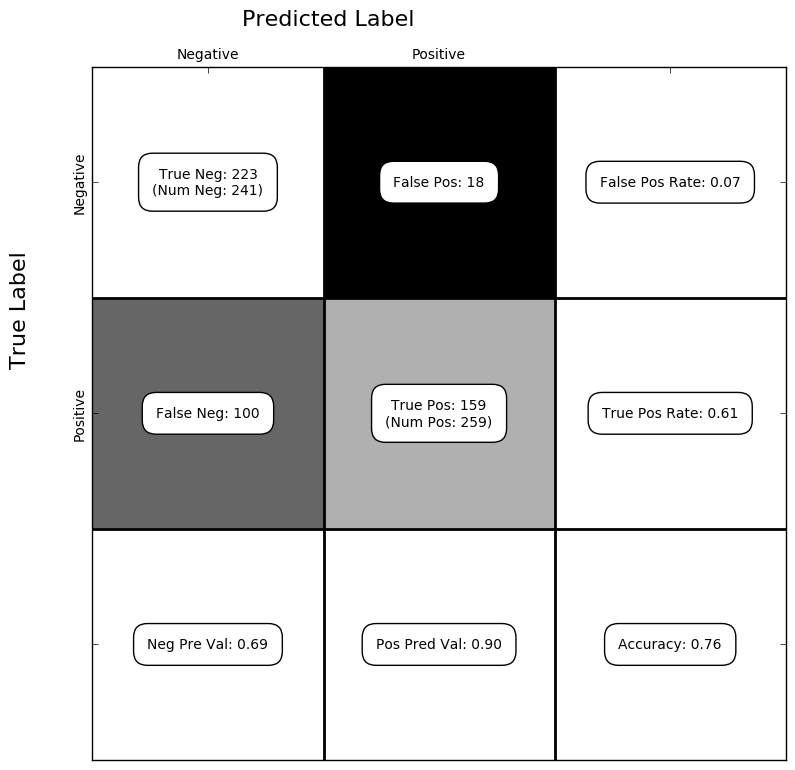

In [28]:
show_confusion_matrix(cm_test,
                     class_labels=["Negative", "Positive"])

----

In [29]:
from sklearn.model_selection import KFold

In [30]:
# Conduct k-fold cross validation
k_fold = KFold(n_splits=10,
               random_state=42)

In [31]:
import numpy as np

In [41]:
accuracy_by_fold = []

for train_index, test_index in k_fold.split(sentiment.data):
    data_train, data_test = np.array(sentiment.data)[train_index], np.array(sentiment.data)[test_index]
    target_train, target_test = np.array(sentiment.target)[train_index], np.array(sentiment.target)[test_index]
    vectorized_train_data = vectorizer_count.fit_transform(data_train)
    clf.fit(vectorized_train_data, target_train)
    accuracy = clf.score(vectorizer_count.transform(data_test), target_test)
    accuracy_by_fold.append(accuracy)

accuracy_by_fold

[0.81000000000000005,
 0.83999999999999997,
 0.84999999999999998,
 0.83999999999999997,
 0.79500000000000004,
 0.81000000000000005,
 0.81000000000000005,
 0.80500000000000005,
 0.79500000000000004,
 0.82999999999999996]

In [42]:
from statistics import mean

In [43]:
print("The average accuracy on the test data is {:.2%}".format(mean(accuracy_by_fold)))

The average accuracy on the test data is 81.85%


<br>
<br> 
<br>

----